# Korean Patent Analysis - AI Trash Sorting System

## **1. Import libraris and related packages**

In [2]:
# Import Libraries and Pacakges

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Set Korean font for matplotlib
plt.rcParams['font.family'] = ['AppleGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## **2. Data Loading and Combine**

In [3]:
# File paths
file_paths = {
    'automatic_sorting': 'data/korean_patents_automatic_sorting_500.csv',
    'computer_vision': 'data/korean_patents_computer_vision_500.csv',
    'recyclable_materials': 'data/korean_patents_recyclable_materials_500.csv',
    'B07C5_34': 'data/korean_patents_B07C5_34_500.csv',
    'G06V10_00': 'data/korean_patents_G06V10_00_16.csv'
}

# Load all CSV files
dataframes = []

for name, file_path in file_paths.items():
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['search_source'] = name
        dataframes.append(df)
        print(f"✓ {name}: {len(df)} records loaded")
    except Exception as e:
        print(f"✗ {name}: {e}")

# Combine all data
combined_df = pd.concat(dataframes, ignore_index=True)
print(f"\nTotal combined: {len(combined_df):,} records")

✓ automatic_sorting: 500 records loaded
✓ computer_vision: 500 records loaded
✓ recyclable_materials: 500 records loaded
✓ B07C5_34: 500 records loaded
✓ G06V10_00: 16 records loaded

Total combined: 2,016 records


## **3. Data Cleaning and Processing**

In [4]:
# Remove duplicates based on invention name + applicant
initial_count = len(combined_df)
clean_df = combined_df.drop_duplicates(subset=['발명의명칭', '출원인'], keep='first')
removed_duplicates = initial_count - len(clean_df)

print(f"Duplicate removal: {removed_duplicates} records removed")
print(f"Clean data: {len(clean_df):,} records")

Duplicate removal: 107 records removed
Clean data: 1,909 records


In [5]:
# Convert date columns
date_columns = ['출원일자', '공개일자', '등록일자', '공고일자']
for col in date_columns:
    if col in clean_df.columns:
        clean_df[col] = pd.to_datetime(clean_df[col], format='%Y.%m.%d', errors='coerce')

# Add year column and filter to 2019-2024
clean_df['application_year'] = clean_df['출원일자'].dt.year
clean_df = clean_df[(clean_df['application_year'] >= 2019) & (clean_df['application_year'] <= 2024)]

print(f"After 2019-2024 filtering: {len(clean_df):,} records")

After 2019-2024 filtering: 1,496 records


In [6]:
# Check missing values
print(f"\nMissing values check:")
important_cols = ['발명의명칭', '출원인', '출원일자', 'IPC분류']
for col in important_cols:
    if col in clean_df.columns:
        missing = clean_df[col].isnull().sum()
        missing_pct = (missing / len(clean_df)) * 100
        print(f"  {col}: {missing} ({missing_pct:.1f}%)")


Missing values check:
  발명의명칭: 0 (0.0%)
  출원인: 0 (0.0%)
  출원일자: 0 (0.0%)
  IPC분류: 0 (0.0%)


## **4. Basic Statistics**

In [7]:
# 1. Yearly trends
yearly_counts = clean_df['application_year'].value_counts().sort_index()
print(f"\nPatent applications by year:")
for year, count in yearly_counts.items():
    if pd.notna(year):
        print(f"  {int(year)}: {count}")


Patent applications by year:
  2019: 220
  2020: 275
  2021: 345
  2022: 299
  2023: 237
  2024: 120


In [8]:
# 2. Year-over-year growth rates
print(f"\nYear-over-year growth:")
for i in range(1, len(yearly_counts)):
    prev_count = yearly_counts.iloc[i-1]
    curr_count = yearly_counts.iloc[i]
    growth = ((curr_count - prev_count) / prev_count) * 100
    curr_year = yearly_counts.index[i]
    print(f"  {int(curr_year)}: {growth:+.1f}%")


Year-over-year growth:
  2020: +25.0%
  2021: +25.5%
  2022: -13.3%
  2023: -20.7%
  2024: -49.4%


In [9]:
# 3. Legal status distribution
if '법적상태' in clean_df.columns:
    legal_status = clean_df['법적상태'].value_counts()
    print(f"\nLegal status distribution:")
    for status, count in legal_status.head(5).items():
        if pd.notna(status):
            pct = (count / len(clean_df)) * 100
            print(f"  {status}: {count} ({pct:.1f}%)")


Legal status distribution:
  등록: 1496 (100.0%)


In [10]:
# 4. Search source effectiveness
source_dist = clean_df['search_source'].value_counts()
print(f"\nSearch strategy effectiveness:")
for source, count in source_dist.items():
    pct = (count / len(clean_df)) * 100
    print(f"  {source}: {count} ({pct:.1f}%)")


Search strategy effectiveness:
  recyclable_materials: 406 (27.1%)
  B07C5_34: 382 (25.5%)
  automatic_sorting: 374 (25.0%)
  computer_vision: 330 (22.1%)
  G06V10_00: 4 (0.3%)


## **5. Application Analysis**

In [11]:
# Top applicants
top_applicants = clean_df['출원인'].value_counts().head(15)
print(f"Top applicants:")
for i, (applicant, count) in enumerate(top_applicants.items(), 1):
    if pd.notna(applicant):
        pct = (count / len(clean_df)) * 100
        print(f"{i:2d}. {applicant}: {count} ({pct:.1f}%)")

Top applicants:
 1. 주식회사 에이트테크(인천광역시 서구...): 12 (0.8%)
 2. 한국화학연구원(대전광역시 유성구...): 10 (0.7%)
 3. 주식회사 라이드플럭스(제주특별자치도 제주시...): 10 (0.7%)
 4. 동의대학교 산학협력단(부산광역시 부산진구...): 10 (0.7%)
 5. 쿠팡 주식회사(서울특별시 송파구...): 8 (0.5%)
 6. 한국생산기술연구원(충청남도 천안시 서북구...): 8 (0.5%)
 7. 주식회사 케이에이치이(경기도 군포시...): 7 (0.5%)
 8. 두인 비전 컴퍼니 리미티드(중국, 베이징 ******, 스징산 디스트릭트, 스싱 로드, 넘버 **,  넘버 *빌딩, *층, 룸 비-****): 7 (0.5%)
 9. 베이징 바이두 넷컴 사이언스 앤 테크놀로지 코., 엘티디.(중국 베이징 ****** 하이뎬 디스트릭트 샹디 **번가 바이두 캠퍼스 *층): 6 (0.4%)
10. 광주과학기술원(광주광역시 북구...): 6 (0.4%)
11. 한국과학기술연구원(서울특별시 성북구...): 6 (0.4%)
12. (주)신대양(부산광역시 기장군...): 6 (0.4%)
13. 구글 엘엘씨(미국 캘리포니아 마운틴 뷰 엠피시어터 파크웨이 **** (우:*****)): 5 (0.3%)
14. 주식회사 와이드테크(경기도 파주시...): 5 (0.3%)
15. 주식회사 티이(인천광역시 남동구...): 5 (0.3%)


In [12]:
# Classify applicant types
def get_applicant_type(applicant):
    if pd.isna(applicant):
        return 'Unclassified'
    applicant = str(applicant).lower()
    if any(word in applicant for word in ['대학교', '대학원', 'university', '연구소', 'institute', '대학', '과학기술원']):
        return 'University/Research'
    elif any(word in applicant for word in ['주식회사', '㈜', 'co.,ltd', 'corp', '회사', '기업', '산업']):
        return 'Company'
    elif any(word in applicant for word in ['재단', '협회', '기관', '센터']):
        return 'Institution'
    else:
        return 'Individual/Other'

clean_df['applicant_type'] = clean_df['출원인'].apply(get_applicant_type)
applicant_types = clean_df['applicant_type'].value_counts()

print(f"\nApplicant type distribution:")
for app_type, count in applicant_types.items():
    pct = (count / len(clean_df)) * 100
    print(f"  {app_type}: {count} ({pct:.1f}%)")


Applicant type distribution:
  Company: 674 (45.1%)
  Individual/Other: 641 (42.8%)
  University/Research: 175 (11.7%)
  Institution: 6 (0.4%)


## **6. Technology Classfication Analysis**

In [13]:
# IPC Analysis - Extract main classes
ipc_main_classes = []
ipc_subclasses = []

for ipc in clean_df['IPC분류'].dropna():
    codes = str(ipc).split('|')  # Use | separator for Korean patent data
    for code in codes:
        code = code.strip()
        if code and len(code) >= 4:
            main_class = code[:4]
            ipc_main_classes.append(main_class)
            if len(code) >= 7:
                subclass = code[:7]
                ipc_subclasses.append(subclass)

# Main IPC classes
ipc_main_counts = Counter(ipc_main_classes)
print(f"Top IPC main classes:")
for ipc, count in ipc_main_counts.most_common(15):
    pct = (count / len(clean_df)) * 100
    print(f"  {ipc}: {count} ({pct:.1f}%)")

Top IPC main classes:
  B07C: 848 (56.7%)
  G06F: 548 (36.6%)
  G06Q: 520 (34.8%)
  G06N: 450 (30.1%)
  G06T: 399 (26.7%)
  G06V: 361 (24.1%)
  G01N: 344 (23.0%)
  B65G: 248 (16.6%)
  H04N: 224 (15.0%)
  B29C: 214 (14.3%)
  B02C: 149 (10.0%)
  B29B: 148 (9.9%)
  B65B: 140 (9.4%)
  G16H: 134 (9.0%)
  A61B: 123 (8.2%)


In [14]:
# Technology focus by search source
print(f"\nTechnology classification by search source:")
for source in clean_df['search_source'].unique():
    source_data = clean_df[clean_df['search_source'] == source]
    source_ipc = []
    for ipc in source_data['IPC분류'].dropna():
        codes = str(ipc).split('|')
        for code in codes:
            code = code.strip()
            if code and len(code) >= 4:
                source_ipc.append(code[:4])
    
    source_ipc_counts = Counter(source_ipc)
    print(f"\n{source} (top 5):")
    for ipc, count in source_ipc_counts.most_common(5):
        pct = (count / len(source_data)) * 100
        print(f"    {ipc}: {count} ({pct:.1f}%)")


Technology classification by search source:

automatic_sorting (top 5):
    G06F: 347 (92.8%)
    G06Q: 276 (73.8%)
    G06N: 197 (52.7%)
    G06V: 134 (35.8%)
    G06T: 126 (33.7%)

computer_vision (top 5):
    G06F: 190 (57.6%)
    H04N: 182 (55.2%)
    G06V: 169 (51.2%)
    G06T: 166 (50.3%)
    G06N: 166 (50.3%)

recyclable_materials (top 5):
    B29C: 185 (45.6%)
    C04B: 116 (28.6%)
    C08L: 113 (27.8%)
    B29B: 112 (27.6%)
    B32B: 111 (27.3%)

B07C5_34 (top 5):
    B07C: 735 (192.4%)
    G01N: 201 (52.6%)
    B65G: 158 (41.4%)
    B02C: 108 (28.3%)
    B65B: 100 (26.2%)

G06V10_00 (top 5):
    G06V: 5 (125.0%)
    G09B: 5 (125.0%)
    G06Q: 3 (75.0%)
    G06F: 3 (75.0%)
    G06T: 2 (50.0%)


## **7. Visualizations**

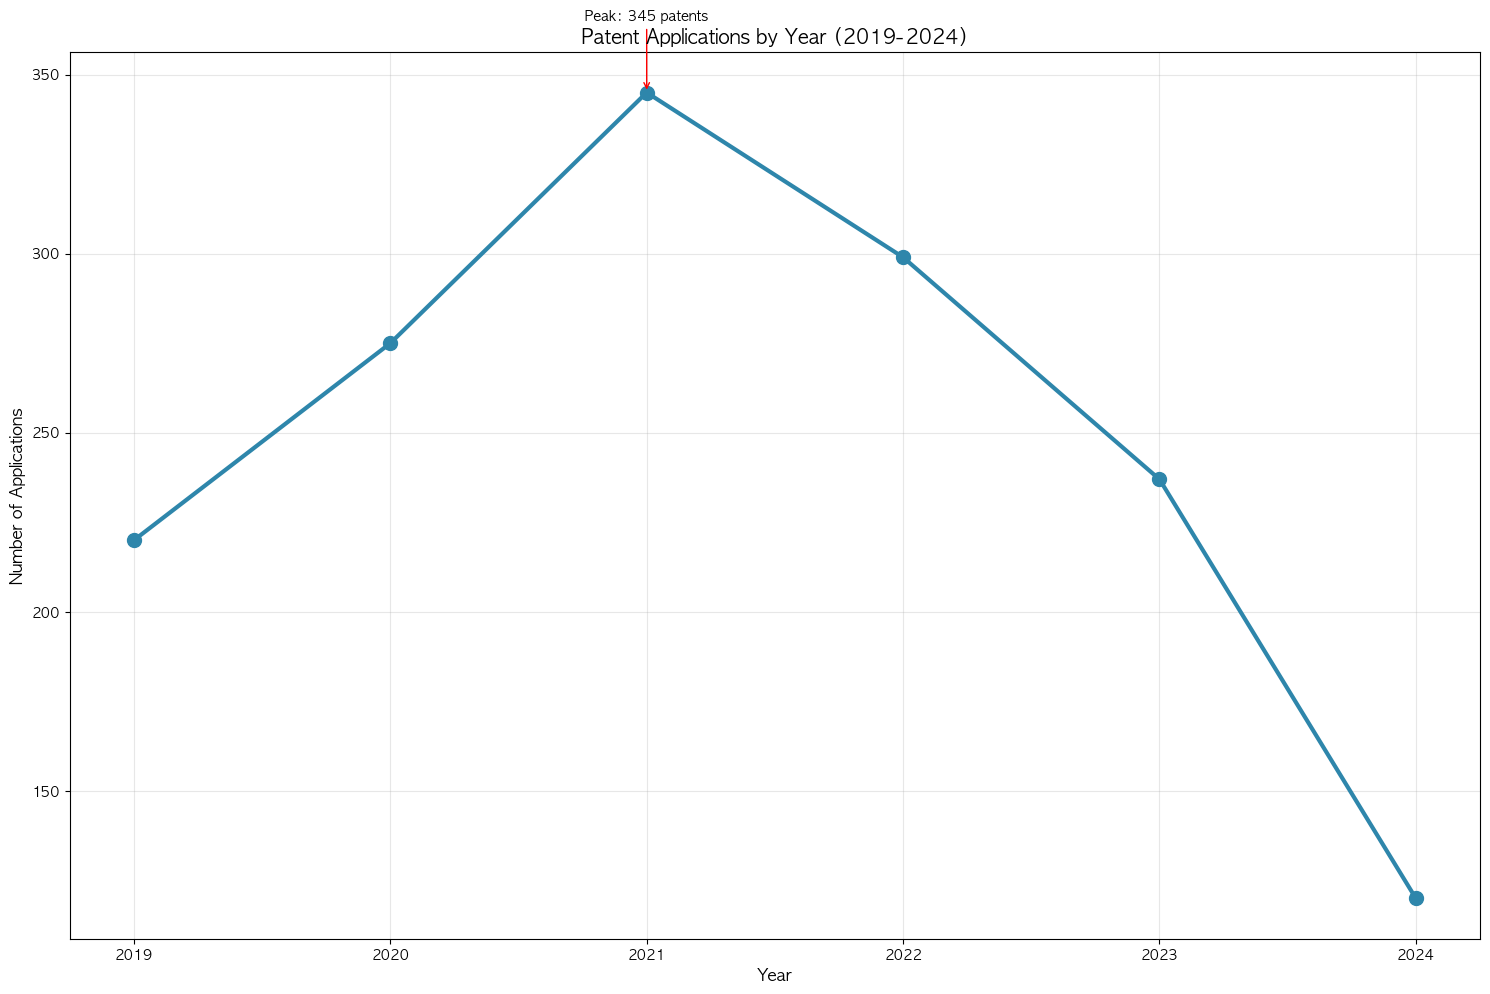

In [15]:
# Yearly Patent Trends

plt.figure(figsize=(15, 10))
yearly_data = clean_df['application_year'].value_counts().sort_index()
plt.plot(yearly_data.index, yearly_data.values, marker='o', linewidth=3, markersize=10, color='#2E86AB')
plt.title('Patent Applications by Year (2019-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Applications', fontsize=12)
plt.grid(True, alpha=0.3)

# Add peak annotation
peak_year = yearly_data.idxmax()
peak_value = yearly_data.max()
plt.annotate(f'Peak: {peak_value} patents', 
             xy=(peak_year, peak_value), 
             xytext=(peak_year, peak_value + 20),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, ha='center')

plt.tight_layout()
plt.show()

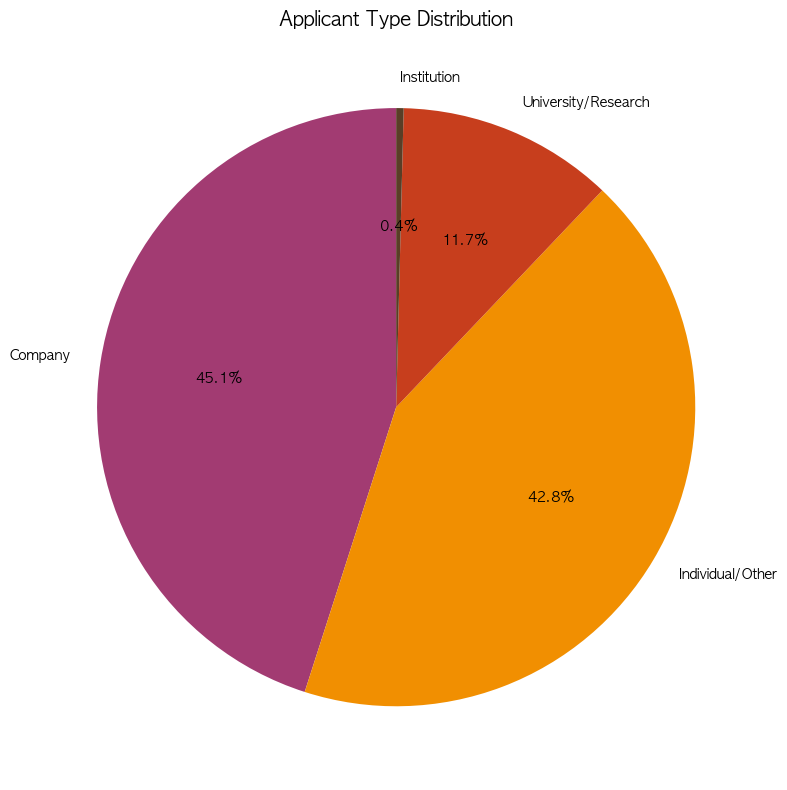

In [16]:
# Applicant Type Distribution

plt.figure(figsize=(8, 8))
colors = ['#A23B72', '#F18F01', '#C73E1D', '#593E26']
applicant_types.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Applicant Type Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

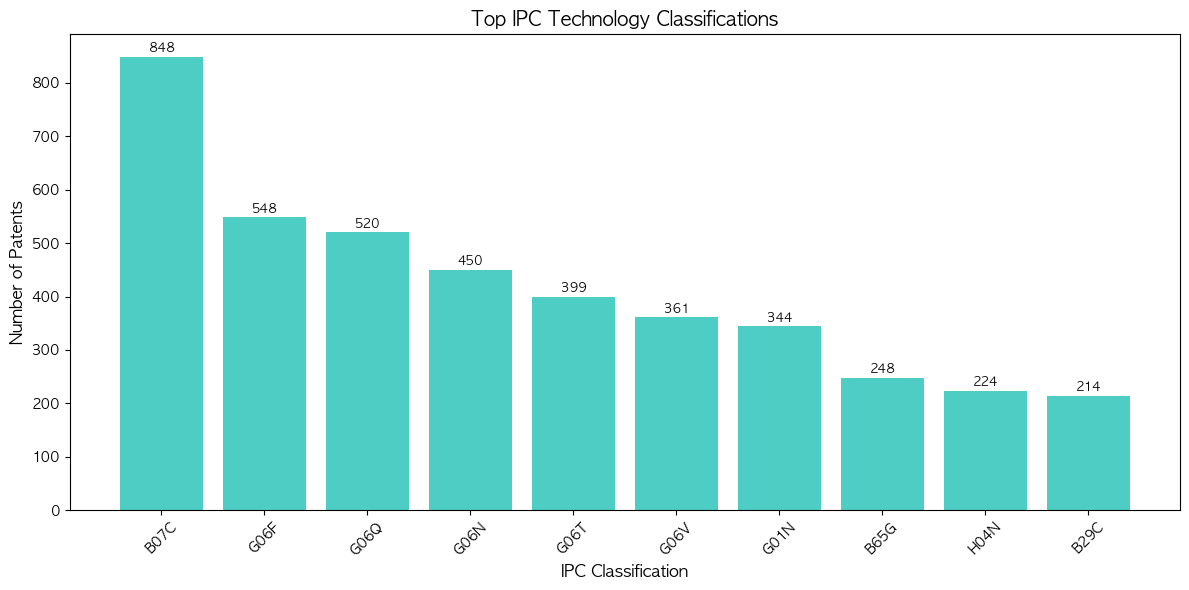

In [17]:
# Top IPC Technology Classifications

plt.figure(figsize=(12, 6))
top_ipc = ipc_main_counts.most_common(10)
ipc_names = [x[0] for x in top_ipc]
ipc_counts = [x[1] for x in top_ipc]

bars = plt.bar(range(len(ipc_names)), ipc_counts, color='#4ECDC4')
plt.title('Top IPC Technology Classifications', fontsize=14, fontweight='bold')
plt.xticks(range(len(ipc_names)), ipc_names, rotation=45)
plt.ylabel('Number of Patents', fontsize=12)
plt.xlabel('IPC Classification', fontsize=12)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

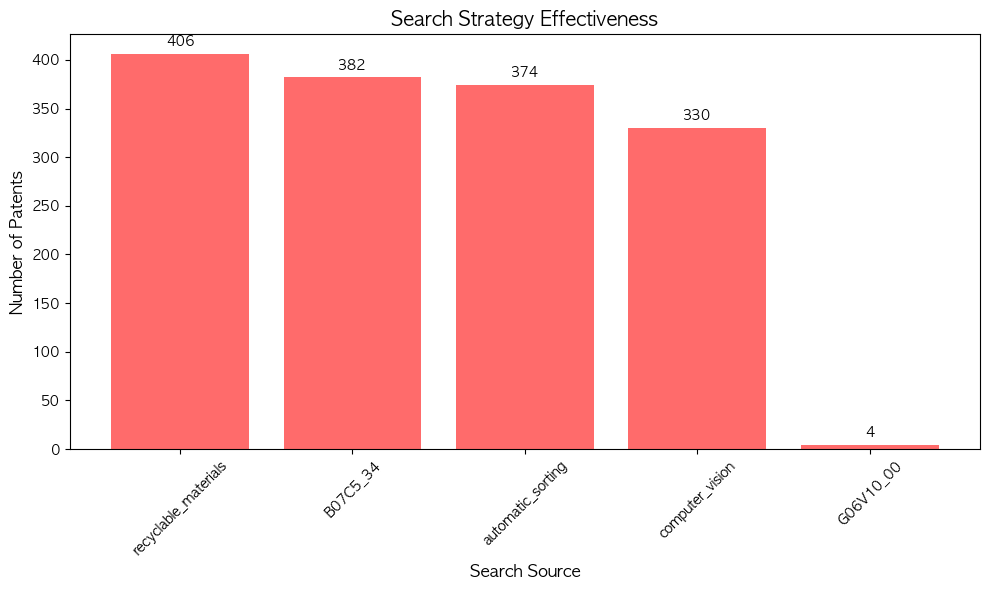

In [18]:
# Search Strategy Effectiveness

plt.figure(figsize=(10, 6))
bars = plt.bar(source_dist.index, source_dist.values, color='#FF6B6B')
plt.title('Search Strategy Effectiveness', fontsize=14, fontweight='bold')
plt.ylabel('Number of Patents', fontsize=12)
plt.xlabel('Search Source', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

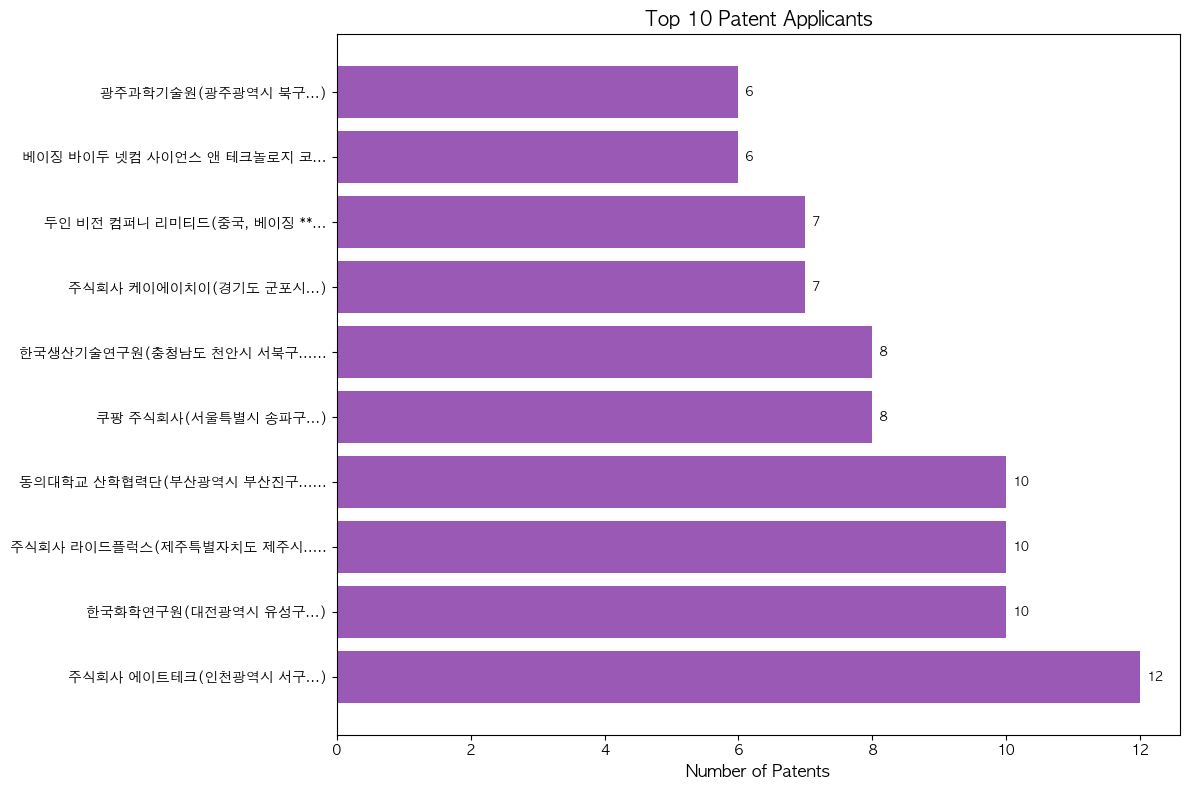

In [19]:
# Top Applicants

plt.figure(figsize=(12, 8))
top_applicants_plot = clean_df['출원인'].value_counts().head(10)
applicant_names = [name[:25] + '...' if len(str(name)) > 25 else name for name in top_applicants_plot.index]

bars = plt.barh(range(len(applicant_names)), top_applicants_plot.values, color='#9B59B6')
plt.yticks(range(len(applicant_names)), applicant_names)
plt.title('Top 10 Patent Applicants', fontsize=14, fontweight='bold')
plt.xlabel('Number of Patents', fontsize=12)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

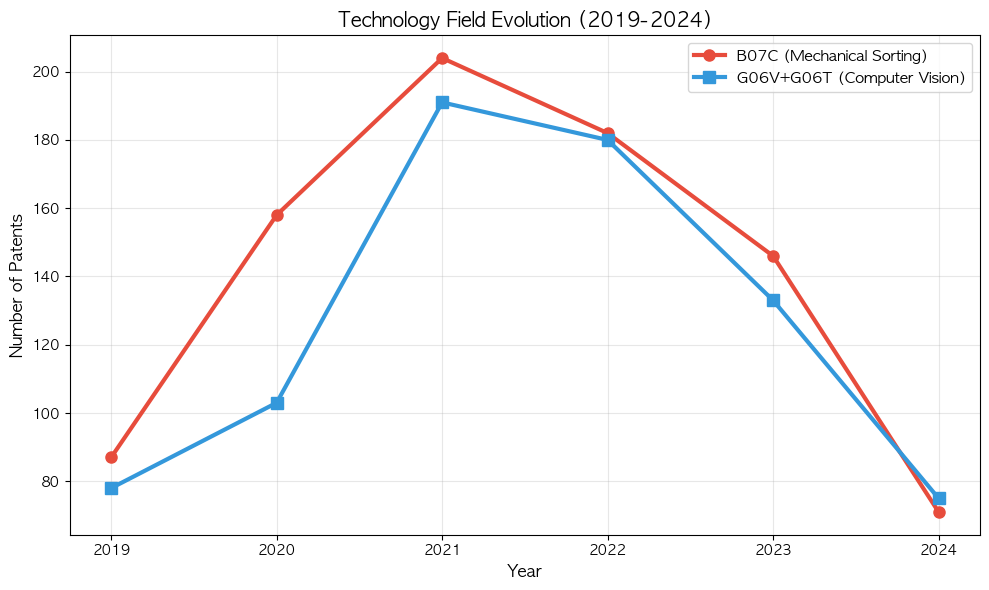

In [20]:
# Technology Evolution Over Time

plt.figure(figsize=(10, 6))

# Calculate technology trends by year
years = sorted(clean_df['application_year'].unique())
b07c_by_year = []
vision_by_year = []

for year in years:
    year_data = clean_df[clean_df['application_year'] == year]
    year_ipc = []
    for ipc in year_data['IPC분류'].dropna():
        codes = str(ipc).split('|')
        for code in codes:
            if code.strip():
                year_ipc.append(code.strip()[:4])
    
    year_counter = Counter(year_ipc)
    b07c_by_year.append(year_counter.get('B07C', 0))
    vision_by_year.append(year_counter.get('G06V', 0) + year_counter.get('G06T', 0))

plt.plot(years, b07c_by_year, marker='o', label='B07C (Mechanical Sorting)', linewidth=3, markersize=8, color='#E74C3C')
plt.plot(years, vision_by_year, marker='s', label='G06V+G06T (Computer Vision)', linewidth=3, markersize=8, color='#3498DB')

plt.title('Technology Field Evolution (2019-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Patents', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## **8. Core Patent Identification**

In [21]:
# Convert citation to numeric
if '피인용 횟수' in clean_df.columns:
    clean_df['citation_count'] = pd.to_numeric(clean_df['피인용 횟수'], errors='coerce').fillna(0)
else:
    clean_df['citation_count'] = 0

# Core patent scoring
clean_df['core_score'] = (
    clean_df['citation_count'] * 3 +  # Citation weight
    (clean_df['법적상태'].str.contains('등록', na=False).astype(int) * 2) +  # Registration status
    (clean_df['application_year'] >= 2021).astype(int) * 1 +  # Recent patents
    (clean_df['IPC분류'].str.contains('B07C', na=False).astype(int) * 2) +  # Sorting technology
    (clean_df['IPC분류'].str.contains('G06V|G06T', na=False).astype(int) * 2)  # AI/Vision
)

# Relevance scoring for AI trash sorting
def get_relevance_score(title, ipc_class):
    score = 0
    title = str(title).lower() if pd.notna(title) else ""
    ipc = str(ipc_class).lower() if pd.notna(ipc_class) else ""
    
    # Keyword scoring
    ai_keywords = ['인공지능', 'ai', '딥러닝', '머신러닝', '학습', '인식', '비전']
    trash_keywords = ['쓰레기', '폐기물', '재활용', '분리수거', '분류', '선별']
    automation_keywords = ['자동', '로봇', '시스템']
    
    for keyword in ai_keywords:
        if keyword in title:
            score += 2
    for keyword in trash_keywords:
        if keyword in title:
            score += 3
    for keyword in automation_keywords:
        if keyword in title:
            score += 1
            
    # IPC relevance
    if 'b07c' in ipc:
        score += 3
    if 'g06v' in ipc or 'g06t' in ipc:
        score += 2
        
    return score

clean_df['relevance_score'] = clean_df.apply(lambda row: get_relevance_score(row['발명의명칭'], row['IPC분류']), axis=1)
clean_df['final_score'] = clean_df['core_score'] + clean_df['relevance_score']

In [22]:
# Select core patents
core_patents = clean_df[
    (clean_df['final_score'] >= 5) |
    (clean_df['relevance_score'] >= 4)
].sort_values('final_score', ascending=False)

print(f"Core patent selection results:")
print(f"- Total patents: {len(clean_df):,}")
print(f"- Core patents: {len(core_patents):,} ({len(core_patents)/len(clean_df)*100:.1f}%)")

# Display top core patents
print(f"\nTop 10 core patents:")
for i, (_, patent) in enumerate(core_patents.head(10).iterrows()):
    print(f"{i+1:2d}. {patent['발명의명칭']}")
    print(f"     Applicant: {patent['출원인']}")
    print(f"     Date: {patent['출원일자'].strftime('%Y-%m-%d') if pd.notna(patent['출원일자']) else 'N/A'}")
    print(f"     Score: {patent['final_score']}")

Core patent selection results:
- Total patents: 1,496
- Core patents: 1,208 (80.7%)

Top 10 core patents:
 1. 인공지능 기반의 재활용 분류 시스템
     Applicant: 주식회사 에이트테크(인천광역시 서구...)
     Date: 2020-07-24
     Score: 68.0
 2. 모듈화된 인공지능 모델 플랫폼 서비스 제공 방법, 장치 및 컴퓨터프로그램
     Applicant: 주식회사 티앤엠테크(서울특별시 서초구...)
     Date: 2020-06-26
     Score: 55.0
 3. 재활용품 자동 분류 수거기
     Applicant: 조선대학교산학협력단(광주광역시 동구...)
     Date: 2019-02-26
     Score: 48.0
 4. 작업 현장의 위험성을 판단하는 인공지능 모델의 학습 방법, 장치 및 컴퓨터프로그램
     Applicant: 주식회사 케이씨씨건설(서울특별시 서초구...)|에이클시스템 주식회사(서울특별시 성동구...)
     Date: 2020-12-23
     Score: 48.0
 5. 영상정보를 이용한 건물 부위별 하자의 자동 판정과 분류 시스템 및 그 방법
     Applicant: 한국건설기술연구원(경기도 고양시 일산서구...)
     Date: 2020-09-14
     Score: 41.0
 6. AI를 활용한 재활용 분류 시스템
     Applicant: 주식회사 에이트테크(인천광역시 서구...)
     Date: 2020-07-24
     Score: 38.0
 7. 딥러닝을 이용한 비정형 재활용품 분류 시스템 및 그 방법
     Applicant: 동명대학교산학협력단(부산광역시 남구...)
     Date: 2020-04-22
     Score: 35.0
 8. 고강력 폴리에스터 장섬유 제조를 위한 재생 PET 칩 제조방법
     Applicant: 이경희(대구광역시 달

In [37]:
core_columns = ['발명의명칭',
                '등록번호',
                '출원인',''
                '출원번호',
                '출원일자',
                '법적상태',
                'search_source',
                'final_score'
                ]

core_table = core_patents[core_columns].head(10)

core_table

,발명의명칭,등록번호,출원인,출원번호,출원일자,법적상태,search_source,final_score
1813,인공지능 기반의 재활용 분류 시스템,1.022220e+12,주식회사 에이트테크(인천광역시 서구...),1.020200e+12,2020-07-24,등록,B07C5_34,68.0
791,"모듈화된 인공지능 모델 플랫폼 서비스 제공 방법, 장치 및 컴퓨터프로그램",1.024090e+12,주식회사 티앤엠테크(서울특별시 서초구...),1.020200e+12,2020-06-26,등록,computer_vision,55.0
18,재활용품 자동 분류 수거기,1.021800e+12,조선대학교산학협력단(광주광역시 동구...),1.020190e+12,2019-02-26,등록,automatic_sorting,48.0
824,"작업 현장의 위험성을 판단하는 인공지능 모델의 학습 방법, 장치 및 컴퓨터프로그램",1.022450e+12,주식회사 케이씨씨건설(서울특별시 서초구...)|에이클시스템 주식회사(서울특별시 성동...,1.020200e+12,2020-12-23,등록,computer_vision,48.0
24,영상정보를 이용한 건물 부위별 하자의 자동 판정과 분류 시스템 및 그 방법,1.022550e+12,한국건설기술연구원(경기도 고양시 일산서구...),1.020200e+12,2020-09-14,등록,automatic_sorting,41.0
1640,AI를 활용한 재활용 분류 시스템,1.022220e+12,주식회사 에이트테크(인천광역시 서구...),1.020200e+12,2020-07-24,등록,B07C5_34,38.0
1770,딥러닝을 이용한 비정형 재활용품 분류 시스템 및 그 방법,1.023920e+12,동명대학교산학협력단(부산광역시 남구...),1.020200e+12,2020-04-22,등록,B07C5_34,35.0
1916,고강력 폴리에스터 장섬유 제조를 위한 재생 PET 칩 제조방법,1.021630e+12,이경희(대구광역시 달서구...)|김혁태(대구광역시 달서구...),1.020190e+12,2019-11-08,등록,B07C5_34,34.0
46,빅데이터를 활용한 판매자 신용 등급 자동집계 및 평가 방법 및 AI 자동 분류 서버,1.020900e+12,(주)디에스솔루션즈(서울특별시 강남구...),1.020190e+12,2019-03-14,등록,automatic_sorting,32.0
341,가스 공급 자동화 시스템,1.024880e+12,삼성전자주식회사(경기도 수원시 영통구...),1.020200e+12,2020-02-21,등록,automatic_sorting,31.0


## **9. Qualitative Analysis**

In [24]:
# Technology keyword analysis
tech_keywords = {
    'AI/ML': ['인공지능', 'ai', '딥러닝', '머신러닝', '학습', '신경망', '알고리즘'],
    'Computer Vision': ['비전', '영상', '이미지', '인식', '검출', '분석', '카메라', '센서'],
    'Automation': ['자동', '로봇', '매니퓰레이터', '제어', '시스템'],
    'Sorting Technology': ['분류', '선별', '분리', '정렬', '구분'],
    'Recycling': ['재활용', '폐기물', '쓰레기', '폐기', '환경', '그린'],
    'Material Recognition': ['플라스틱', '페트', '종이', '금속', '유리', '섬유'],
    'Data Processing': ['데이터', '정보', '처리', '분석', '관리', '클라우드']
}

results = defaultdict(int)
total_patents = len(clean_df)

In [25]:
for title in clean_df['발명의명칭']:
    if pd.notna(title):
        title_lower = str(title).lower()
        for category, keywords in tech_keywords.items():
            for keyword in keywords:
                if keyword in title_lower:
                    results[category] += 1
                    break

tech_distribution = {cat: (count/total_patents)*100 for cat, count in results.items()}

print("Technology field distribution (from patent titles):")
for category, percentage in sorted(tech_distribution.items(), key=lambda x: x[1], reverse=True):
    count = results[category]
    print(f"  {category}: {count} patents ({percentage:.1f}%)")

Technology field distribution (from patent titles):
  Automation: 729 patents (48.7%)
  Recycling: 374 patents (25.0%)
  Sorting Technology: 364 patents (24.3%)
  Computer Vision: 319 patents (21.3%)
  Data Processing: 226 patents (15.1%)
  AI/ML: 205 patents (13.7%)
  Material Recognition: 116 patents (7.8%)


In [26]:
# Technology by applicant type analysis
print(f"\nTechnology focus by applicant type:")
for category, keywords in [
    ('AI/ML', ['인공지능', 'ai', '딥러닝', '머신러닝']),
    ('Computer Vision', ['비전', '영상', '이미지', '인식']),
    ('Automation', ['자동', '로봇', '시스템']),
    ('Recycling', ['재활용', '폐기물', '쓰레기'])
]:
    tech_patents = clean_df[
        clean_df['발명의명칭'].str.contains('|'.join(keywords), case=False, na=False)
    ]
    
    if len(tech_patents) > 0:
        applicant_dist = tech_patents['applicant_type'].value_counts()
        print(f"\n{category} ({len(tech_patents)} patents):")
        for app_type, count in applicant_dist.items():
            pct = (count / len(tech_patents)) * 100
            print(f"  {app_type}: {count} ({pct:.1f}%)")


Technology focus by applicant type:

AI/ML (166 patents):
  Company: 80 (48.2%)
  Individual/Other: 58 (34.9%)
  University/Research: 26 (15.7%)
  Institution: 2 (1.2%)

Computer Vision (247 patents):
  Company: 118 (47.8%)
  Individual/Other: 81 (32.8%)
  University/Research: 47 (19.0%)
  Institution: 1 (0.4%)

Automation (717 patents):
  Company: 339 (47.3%)
  Individual/Other: 281 (39.2%)
  University/Research: 94 (13.1%)
  Institution: 3 (0.4%)

Recycling (326 patents):
  Company: 162 (49.7%)
  Individual/Other: 137 (42.0%)
  University/Research: 26 (8.0%)
  Institution: 1 (0.3%)


## **10. Social Network Analysis**

In [27]:
# Technology co-occurrence network
tech_network = nx.Graph()

for _, patent in clean_df.iterrows():
    ipc_codes = str(patent['IPC분류']) if pd.notna(patent['IPC분류']) else ""
    if ipc_codes:
        codes = [code.strip()[:4] for code in ipc_codes.split('|') 
                if len(code.strip()) >= 4]
        
        # Add edges between all pairs of technologies in same patent
        for i in range(len(codes)):
            for j in range(i+1, len(codes)):
                if codes[i] != codes[j]:
                    if tech_network.has_edge(codes[i], codes[j]):
                        tech_network[codes[i]][codes[j]]['weight'] += 1
                    else:
                        tech_network.add_edge(codes[i], codes[j], weight=1)

print(f"Technology network created:")
print(f"  - Technology nodes: {tech_network.number_of_nodes()}")
print(f"  - Technology connections: {tech_network.number_of_edges()}")

# Network centrality analysis
if tech_network.number_of_nodes() > 0:
    degree_centrality = nx.degree_centrality(tech_network)
    betweenness_centrality = nx.betweenness_centrality(tech_network)
    
    print(f"\nDegree Centrality (Top 10):")
    print("(Technologies that appear with many other technologies)")
    for i, (tech, cent) in enumerate(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 1):
        connections = tech_network.degree(tech)
        print(f"{i:2d}. {tech}: {cent:.3f} ({connections} connections)")
    
    print(f"\nBetweenness Centrality (Top 10):")
    print("(Technologies that bridge different technology areas)")
    for i, (tech, cent) in enumerate(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 1):
        if cent > 0:
            print(f"{i:2d}. {tech}: {cent:.3f}")

    # Strongest technology pairs
    print(f"\nStrongest technology connections (Top 15):")
    print("(Technology combinations that appear together most often)")
    
    if tech_network.number_of_edges() > 0:
        weighted_edges = [(u, v, data['weight']) for u, v, data in tech_network.edges(data=True)]
        weighted_edges.sort(key=lambda x: x[2], reverse=True)
        
        for i, (tech1, tech2, weight) in enumerate(weighted_edges[:15], 1):
            print(f"{i:2d}. {tech1} ↔ {tech2}: {weight} co-occurrences")

Technology network created:
  - Technology nodes: 310
  - Technology connections: 1635

Degree Centrality (Top 10):
(Technologies that appear with many other technologies)
 1. B07C: 0.401 (124 connections)
 2. G06N: 0.265 (82 connections)
 3. G06Q: 0.243 (75 connections)
 4. G06T: 0.217 (67 connections)
 5. B09B: 0.207 (64 connections)
 6. G06V: 0.204 (63 connections)
 7. G01N: 0.201 (62 connections)
 8. B65G: 0.197 (61 connections)
 9. B29C: 0.194 (60 connections)
10. G06F: 0.172 (53 connections)

Betweenness Centrality (Top 10):
(Technologies that bridge different technology areas)
 1. B07C: 0.251
 2. G06N: 0.087
 3. B29C: 0.080
 4. B09B: 0.066
 5. G06Q: 0.065
 6. G06T: 0.049
 7. B65G: 0.049
 8. G06F: 0.047
 9. G01N: 0.039
10. G06V: 0.039

Strongest technology connections (Top 15):
(Technology combinations that appear together most often)
 1. G06F ↔ G06Q: 445 co-occurrences
 2. G06V ↔ G06N: 375 co-occurrences
 3. G06N ↔ G06F: 326 co-occurrences
 4. B65G ↔ B07C: 319 co-occurrences
 5.

In [28]:
# 3. Network Visualization Generation 

if tech_network.number_of_nodes() > 0:
    print("\n--- Generating Network Visualization ---")
    
    # Set up the plot with explicit Axes object (ax)
    fig, ax = plt.subplots(figsize=(18, 18), dpi=100)
    ax.set_title('Technology Co-occurrence Network', fontsize=25)

    # Calculate metrics for visualization
    degree_centrality = nx.degree_centrality(tech_network)
    betweenness_centrality = nx.betweenness_centrality(tech_network)
    
    # Use a layout algorithm to position nodes
    # k controls the distance between nodes. Adjust if nodes are too close/far.
    pos = nx.spring_layout(tech_network, k=0.5, iterations=50, seed=42)

    # --- Node Attributes ---
    # Set node size based on its degree (number of connections)
    node_sizes = [v * 10000 for v in degree_centrality.values()]
    # Set node color based on its betweenness centrality (bridging role)
    node_colors = list(betweenness_centrality.values())
    
    # --- Edge Attributes ---
    # Set edge width based on its weight (co-occurrence frequency)
    edge_weights = [tech_network[u][v]['weight'] for u, v in tech_network.edges()]
    
    # Draw the network, passing the 'ax' argument to all drawing functions
    nodes = nx.draw_networkx_nodes(tech_network, pos, 
                           ax=ax,
                           node_size=node_sizes, 
                           node_color=node_colors, 
                           cmap=plt.cm.viridis, # Colormap for nodes
                           alpha=0.8)

    nx.draw_networkx_edges(tech_network, pos, 
                           ax=ax,
                           width=edge_weights, 
                           edge_color='#cccccc', # Light grey for edges
                           alpha=0.7)

    nx.draw_networkx_labels(tech_network, pos, 
                            ax=ax,
                            font_size=12, 
                            font_family='sans-serif',
                            font_weight='bold')

    # Add a color bar, linking it to the specific axes 'ax'
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.5)
    cbar.set_label('Betweenness Centrality', rotation=270, labelpad=15)
    
    # Save the plot to a file
    file_path = 'tech_network.png'
    fig.savefig(file_path, format='PNG', bbox_inches='tight')
    
    plt.close(fig) # Close the specific figure to free up memory
    
    print(f"Successfully saved network graph to '{file_path}'")
else:
    print("\nNetwork is empty. No visualization will be generated.")


--- Generating Network Visualization ---
Successfully saved network graph to 'tech_network.png'


## 11. **Claims Analysis**

In [29]:
# Select top 10 core patents for detailed analysis
top_core_patents = core_patents.head(10)

print(f"Detailed analysis of top {len(top_core_patents)} core patents:")

claims_analysis_results = []

for i, (_, patent) in enumerate(top_core_patents.iterrows(), 1):
    print(f"\n{i:2d}. {patent['발명의명칭']}")
    print(f"    Applicant: {patent['출원인']}")
    print(f"    Date: {patent['출원일자'].strftime('%Y-%m-%d') if pd.notna(patent['출원일자']) else 'N/A'}")
    print(f"    IPC: {patent['IPC분류']}")
    
    analysis_result = {
        'patent_name': patent['발명의명칭'],
        'applicant': patent['출원인'],
        'ipc_classes': [],
        'technical_elements': [],
        'patent_type': '',
        'protection_scope': 0
    }
    
    # Analyze IPC classifications for protection scope
    ipc_codes = str(patent['IPC분류'])
    unique_classes = set()
    if pd.notna(ipc_codes):
        for code in ipc_codes.split('|'):
            if len(code.strip()) >= 4:
                main_class = code.strip()[:4]
                unique_classes.add(main_class)
                analysis_result['ipc_classes'].append(main_class)
    
    analysis_result['protection_scope'] = len(unique_classes)
    # Analyze technical elements
    title = str(patent['발명의명칭']).lower()
    abstract = str(patent.get('요약', '')).lower() if '요약' in patent and pd.notna(patent['요약']) else ''
    
    technical_components = {
        'Image Processing': ['카메라', '촬영', '영상', '이미지', 'vision', '비전'],
        'AI/ML': ['인공지능', 'ai', '딥러닝', '머신러닝', '학습', '신경망'],
        'Auto Classification': ['분류', '선별', '분리', '정렬', '자동'],
        'Sensor Technology': ['센서', '검출', '측정', 'sensor'],
        'Robotics': ['로봇', '매니퓰레이터', '제어', 'robot'],
        'Data Processing': ['데이터', '처리', '분석', '알고리즘'],
        'Recycling': ['재활용', '폐기물', '쓰레기', '환경']
    }
    
    for component, keywords in technical_components.items():
        if any(keyword in title or keyword in abstract for keyword in keywords):
            analysis_result['technical_elements'].append(component)

    # Determine patent type
    if '방법' in patent['발명의명칭'] or '단계' in title:
        analysis_result['patent_type'] = 'Method Patent'
    elif '시스템' in patent['발명의명칭'] or '장치' in title:
        analysis_result['patent_type'] = 'System/Apparatus Patent'
    else:
        analysis_result['patent_type'] = 'Hybrid Patent'
    
    claims_analysis_results.append(analysis_result)
    
    print(f"    Technical Elements: {', '.join(analysis_result['technical_elements']) if analysis_result['technical_elements'] else 'Basic sorting technology'}")
    print(f"    Patent Type: {analysis_result['patent_type']}")
    scope_level = 'Broad' if analysis_result['protection_scope'] >= 5 else 'Medium' if analysis_result['protection_scope'] >= 3 else 'Narrow'
    print(f"    Protection Scope: {analysis_result['protection_scope']} IPC classes ({scope_level})")

# Summary analysis
print(f"\n=== Claims Analysis Summary ===")


Detailed analysis of top 10 core patents:

 1. 인공지능 기반의 재활용 분류 시스템
    Applicant: 주식회사 에이트테크(인천광역시 서구...)
    Date: 2020-07-24
    IPC: G06V 10/764(2022.01)|G06V 10/70(2022.01)|G06V 10/56(2022.01)|G06T 7/90(2017.01)|G06T 7/00(2017.01)|G06N 3/08(2023.01)|B07C 5/342(2006.01)|B07C 5/38(2006.01)|B07C 5/36(2006.01)
    Technical Elements: Image Processing, AI/ML, Auto Classification, Data Processing, Recycling
    Patent Type: System/Apparatus Patent
    Protection Scope: 4 IPC classes (Medium)

 2. 모듈화된 인공지능 모델 플랫폼 서비스 제공 방법, 장치 및 컴퓨터프로그램
    Applicant: 주식회사 티앤엠테크(서울특별시 서초구...)
    Date: 2020-06-26
    IPC: G06F 8/35(2018.01)|G06F 8/36(2018.01)|G06F 8/38(2018.01)|G06F 9/451(2018.01)
    Technical Elements: AI/ML
    Patent Type: Method Patent
    Protection Scope: 1 IPC classes (Narrow)

 3. 재활용품 자동 분류 수거기
    Applicant: 조선대학교산학협력단(광주광역시 동구...)
    Date: 2019-02-26
    IPC: B65F 1/00(2006.01)|B65F 1/14(2006.01)|G06N 20/00(2019.01)|B65G 65/38(2006.01)|B65G 15/30(2014.01)
    Technical Eleme

In [30]:
# Technology component frequency
all_components = []
for result in claims_analysis_results:
    all_components.extend(result['technical_elements'])

component_freq = Counter(all_components)
print("Key technical components in core patents:")
for component, freq in component_freq.most_common():
    percentage = (freq / len(claims_analysis_results)) * 100
    print(f"  {component}: {freq} patents ({percentage:.0f}%)")

Key technical components in core patents:
  Auto Classification: 8 patents (80%)
  AI/ML: 7 patents (70%)
  Data Processing: 7 patents (70%)
  Image Processing: 6 patents (60%)
  Recycling: 4 patents (40%)
  Robotics: 2 patents (20%)
  Sensor Technology: 1 patents (10%)


In [31]:
# Patent type distribution
patent_types = [result['patent_type'] for result in claims_analysis_results]
type_freq = Counter(patent_types)
print(f"\nPatent type distribution:")
for ptype, freq in type_freq.items():
    percentage = (freq / len(claims_analysis_results)) * 100
    print(f"  {ptype}: {freq} patents ({percentage:.0f}%)")


Patent type distribution:
  System/Apparatus Patent: 3 patents (30%)
  Method Patent: 6 patents (60%)
  Hybrid Patent: 1 patents (10%)


In [32]:
# Protection scope analysis
scopes = [result['protection_scope'] for result in claims_analysis_results]
avg_scope = np.mean(scopes)
print(f"\nProtection scope analysis:")
print(f"  Average IPC classes: {avg_scope:.1f}")
print(f"  Maximum scope: {max(scopes)} classes")
print(f"  Minimum scope: {min(scopes)} classes")


Protection scope analysis:
  Average IPC classes: 2.9
  Maximum scope: 5 classes
  Minimum scope: 1 classes


## **12. Data Export**

In [33]:
# Save cleaned data
clean_df.to_csv('export/cleaned_patent_data.csv', index=False, encoding='utf-8-sig')
core_patents.to_csv('export/core_patents.csv', index=False, encoding='utf-8-sig')

# Create summary statistics
summary_stats = {
    'analysis_period': '2019-2024',
    'total_patents': len(clean_df),
    'core_patents': len(core_patents),
    'peak_year': int(yearly_counts.idxmax()),
    'main_ipc_class': ipc_main_counts.most_common(1)[0][0],
    'top_applicant': clean_df['출원인'].value_counts().index[0],
    'company_ratio': f"{(applicant_types.get('Company', 0) / len(clean_df)) * 100:.1f}%",
    'university_ratio': f"{(applicant_types.get('University/Research', 0) / len(clean_df)) * 100:.1f}%"
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('export/analysis_summary.csv', index=False, encoding='utf-8-sig')

print(f"Files saved successfully:")
print(f"✓ cleaned_patent_data.csv - Complete cleaned patent data")
print(f"✓ core_patents.csv - Core patent data")
print(f"✓ analysis_summary.csv - Analysis summary statistics")

Files saved successfully:
✓ cleaned_patent_data.csv - Complete cleaned patent data
✓ core_patents.csv - Core patent data
✓ analysis_summary.csv - Analysis summary statistics
